In [2]:
# https://www.kaggle.com/mathormad/inceptionv3-baseline-lb-0-379/code

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle

import warnings
warnings.filterwarnings("ignore")
SIZE = 512

In [4]:
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric/notebook
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) + (1 - K.mean(f1))

# POS_WEIGHT = 1.0  # multiplier for positive targets, needs to be tuned

# def weighted_binary_crossentropy(target, output):
#     """
#     Weighted binary crossentropy between an output tensor 
#     and a target tensor. POS_WEIGHT is used as a multiplier 
#     for the positive targets.

#     Combination of the following functions:
#     * keras.losses.binary_crossentropy
#     * keras.backend.tensorflow_backend.binary_crossentropy
#     * tf.nn.weighted_cross_entropy_with_logits
#     """
#     # transform back to logits
# #     _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
#     _epsilon = K.epsilon()
#     output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
#     output = tf.log(output / (1 - output))
#     # compute weighted loss
#     loss = tf.nn.weighted_cross_entropy_with_logits(targets=target,
#                                                     logits=output,
#                                                     pos_weight=POS_WEIGHT)
#     return tf.reduce_mean(loss, axis=-1)

# import tensorflow as tf
# from tensorflow.python.framework import ops
# from functools import reduce

# def binaryRound(x):
#     """
#     Rounds a tensor whose values are in [0,1] to a tensor with values in {0, 1},
#     using the straight through estimator for the gradient.
#     """
#     g = tf.get_default_graph()

#     with ops.name_scope("BinaryRound") as name:
#         with g.gradient_override_map({"Round": "Identity"}):
#             return tf.round(x, name=name)

#         # For Tensorflow v0.11 and below use:
#         #with g.gradient_override_map({"Floor": "Identity"}):
#         #    return tf.round(x, name=name)
        
# def f1_loss2(y_true, y_pred):
#     y_pred = binaryRound(y_pred)
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
#     return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) + (1-K.mean(f1))

In [5]:
# Load dataset info
path_to_train = '../data/train/'
data = pd.read_csv('../data/train.csv')

In [6]:
data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [7]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [8]:
train_dataset_info

array([{'path': '../data/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': '../data/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': '../data/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': '../data/train/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])},
       {'path': '../data/train/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])},
       {'path': '../data/train/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}],
      dtype=object)

In [9]:
submit = pd.read_csv('../data/sample_submission.csv')
path_to_test = '../data/test/'
test_dataset_info = []
for name in tqdm(submit['Id']):
    test_dataset_info.append({
        'path':os.path.join(path_to_test, name)})
test_dataset_info = np.array(test_dataset_info)

100%|██████████| 11702/11702 [00:00<00:00, 107684.53it/s]


In [10]:
# rgb_arr = np.memmap('../cache/tmp_rgb_arr', dtype='uint8', mode='r+', 
#                    shape=(len(train_dataset_info),299,299,3))

In [11]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape) 
#                     image = data_generator.load_image(
#                         i, shape) 
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels
    def create_train2(dataset_info, batch_size, shape, augument=False):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape) 
#                     image = data_generator.load_image(
#                         i, shape) 
                    
                    batch_images.append(image/255.)
                    
                yield np.array(batch_images, np.float32), None
    def create_test(dataset_info, batch_size, shape, augument=False):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_test_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_test_batch), 28))
                for i in range(len(X_test_batch)):
                    image = data_generator.load_image(
                        X_test_batch[i]['path'], shape) 
#                     image = data_generator.load_image(
#                         i, shape) 
                    
                    batch_images.append(image/255.)
                    
                yield np.array(batch_images, np.float32), None
    def load_image(path, shape):
        img1 = cv2.imread(path+'_red.png', cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(path+'_green.png', cv2.IMREAD_GRAYSCALE)
        img3 = cv2.imread(path+'_blue.png', cv2.IMREAD_GRAYSCALE)
        image = np.stack((img1,img2,img3), -1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    def load_image3(idx, shape):
#         print(idx)
        name = '../cache/RGB/img-{}.png'.format(idx)
        image = cv2.imread(name)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    def load_image2(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
#         zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_yellow_ch),
#             zero_data, zero_data), -1)
#         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2))
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def augment2(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Affine(rotate=0),
                    iaa.Affine(rotate=90),
                    iaa.Affine(rotate=180),
                    iaa.Affine(rotate=270),
                    iaa.Flipud(0.5),
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug
    

In [43]:
32000/(22 * 60)

24.242424242424242

In [12]:
import keras as k
print(k.__version__)

Using TensorFlow backend.


2.2.4


In [13]:
# !pip install -U keras

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv2D
from keras.layers import UpSampling2D, Lambda, Reshape, Conv2DTranspose
from keras.layers import  MaxPooling2D, concatenate, merge, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [15]:
def create_model(input_shape1, input_shape2, input_shape3, input_shape4, n_out):
    input_tensor1 = Input(shape=input_shape1)
    
    input_tensor2 = Input(shape=input_shape2)
    
    input_tensor3 = Input(shape=input_shape3)
    
    input_tensor4 = Input(shape=input_shape4)
    
    x1 = Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', name='conv1a')(input_tensor1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x1 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv2a')(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x1 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv3a')(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x2 = Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', name='conv1b')(input_tensor2)
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
    
    x2 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv2b')(x2)
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
    
    x2 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv3b')(x2)
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
    
    x3 = Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', name='conv1c')(input_tensor3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    
    x3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv2c')(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    
    x3 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv3c')(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    
    x4 = Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', name='conv1d')(input_tensor4)
    x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    
    x4 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv2d')(x4)
    x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    
    x4 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv3d')(x4)
    x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    
    x = concatenate([x1, x2, x3, x4], axis=3)

    x = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv4')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same', data_format=None)(x)
    
    output = Conv2D(n_out, kernel_size=(3,3), activation='sigmoid', padding='same', name='confidence_map')(x)
    
    model = Model([input_tensor1, input_tensor2, input_tensor3, input_tensor4], output)
    
    return model

In [16]:
# model = create_model(
#     input_shape1=(SIZE,SIZE, 1), input_shape2=(SIZE,SIZE,1), input_shape3=(SIZE,SIZE,1), 
#     input_shape4=(SIZE,SIZE,1),
#     n_out=28)
# model.summary()

In [17]:
path = train_dataset_info[0]['path']
print(path)
img = cv2.imread(path+'_green.png', cv2.IMREAD_GRAYSCALE)
# img = np.dstack((img,img,img))

../data/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0


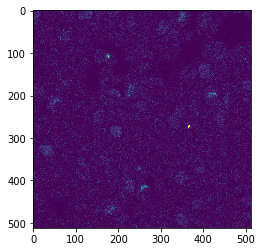

In [18]:
plt.imshow(img)

In [19]:
img.shape

(512, 512)

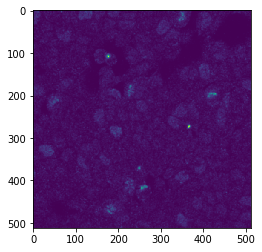

In [20]:
blur = cv2.GaussianBlur(img,(5,5),0)
plt.imshow(blur)

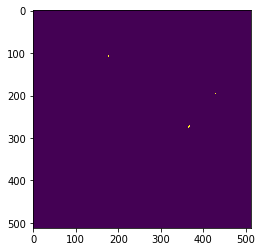

In [21]:
ret,thresh1 = cv2.threshold(blur,127,255,cv2.THRESH_BINARY)
plt.imshow(thresh1)

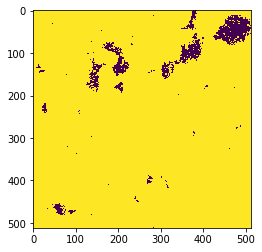

In [23]:
ret,thresh1 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY)
plt.imshow(thresh1)

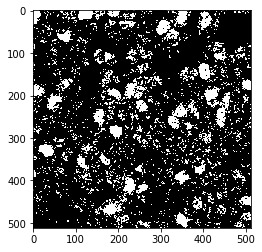

In [41]:
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th3, cmap='gray')

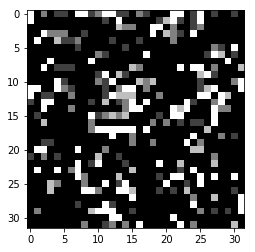

In [36]:
th4 = cv2.resize(th3, (32,32))
plt.imshow(th4, cmap='gray')

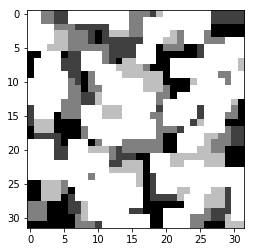

In [40]:
kernel = np.ones((3,3), np.uint8) 
img_dilation = cv2.dilate(th4, kernel, iterations=1) 
plt.imshow(img_dilation, cmap='gray')

In [68]:
latent_dim = 16
kernel_size = 3
layer_filters = [32, 64, 128, 256, 512]
from keras.regularizers import l2
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
#     w = K.get_session().run(base_model.trainable_weights)
#     print(w.shape)
    x = GlobalAveragePooling2D()(x)
    W_x = Dense(x.shape[1], kernel_initializer='glorot_uniform', use_bias=True, kernel_regularizer=l2(0.))
    print(W_x.shape)
    x = K.dot(x, W_x)
    print(x.shape)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    output = Dense(n_out, activation='sigmoid', name='output')(x)
    model = Model(input_tensor, output)
    
    return model

In [69]:
401408/(16*16)

1568.0

In [70]:
(401408*14*14)/(16*16)

307328.0

In [71]:
model = create_model(
    input_shape1=(SIZE,SIZE,3), n_out=28)
model.summary()

AttributeError: 'Dense' object has no attribute 'get_shape'

In [50]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 10; batch_size = 16
checkpoint = ModelCheckpoint('../cache/iv3-40.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]


In [51]:

# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)




In [52]:
# warm up model
# model = create_model(
#     input_shape=(SIZE,SIZE,3), 
#     n_out=28)
model.summary()

for layer in model.layers:
    layer.trainable = True
model.layers[0].trainable = False
model.layers[1].trainable = False
model.layers[2].trainable = False


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
batch_normalization_855 (Bat (None, 512, 512, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 28)                28700     
Total para

In [53]:
model.compile(
    loss=[f1_loss], 
    optimizer=Adam(1e-03),
    metrics=[f1])


In [54]:
print(len(train_indexes), len(valid_indexes))

26411 4661


In [57]:
batch_size=16

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=2, 
    verbose=1)

Epoch 1/2
  62/1651 [>.............................] - ETA: 23:42 - loss: 1.1870 - f1: 0.0339

KeyboardInterrupt: 

In [51]:
epochs=120

# batch_size=8
for layer in model.layers:
    layer.trainable = True
model.compile(loss=[f1_loss, 'mse'],
              optimizer=Adam(lr=1e-4),
              loss_weights = {"output": 1.0, "img_out": 10.0 }, 
              metrics=[f1])

In [52]:
# train all layers
batch_size=4

train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 8, (SIZE,SIZE,3), augument=False)
# model.load_weights('../cache/iv3-38.h5')
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=epochs, 
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/120
6603/6603 [==============================] - 2147s 325ms/step - loss: 1.3233 - output_loss: 1.0986 - img_out_loss: 0.0225 - output_f1: 0.0505 - img_out_f1: 0.0000e+00 - val_loss: 1.2780 - val_output_loss: 1.0541 - val_img_out_loss: 0.0224 - val_output_f1: 0.1139 - val_img_out_f1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.27798, saving model to ../cache/iv3-40.h5
Epoch 2/120
6603/6603 [==============================] - 2071s 314ms/step - loss: 1.2767 - output_loss: 1.0522 - img_out_loss: 0.0225 - output_f1: 0.0803 - img_out_f1: 0.0000e+00 - val_loss: 1.2467 - val_output_loss: 1.0228 - val_img_out_loss: 0.0224 - val_output_f1: 0.1378 - val_img_out_f1: 0.0000e+00

Epoch 00002: val_loss improved from 1.27798 to 1.24667, saving model to ../cache/iv3-40.h5
Epoch 3/120
6603/6603 [==============================] - 2029s 307ms/step - loss: 1.2553 - output_loss: 1.0307 - img_out_loss: 0.0225 - output_f1: 0.0934 - img_out_f1: 0.0000e+00 - val_loss: 1.2240 - val_output_l

In [53]:
# for ii in tqdm(np.arange(len(train_dataset_info))):
#     img1 = cv2.imread(train_dataset_info[ii]['path']+'_red.png', cv2.IMREAD_GRAYSCALE)
#     img2 = cv2.imread(train_dataset_info[ii]['path']+'_green.png', cv2.IMREAD_GRAYSCALE)
#     img3 = cv2.imread(train_dataset_info[ii]['path']+'_blue.png', cv2.IMREAD_GRAYSCALE)
#     img1 = np.stack((img1, img2, img3), -1)
#     name = '../cache/RGB/img-{}.png'.format(ii)
#     cv2.imwrite(name,img1)

In [54]:
# submit = pd.read_csv('../data/sample_submission.csv')
# for name in tqdm(submit['Id']):
#     path = os.path.join('../data/test/', name)
#     img1 = cv2.imread(path+'_red.png', cv2.IMREAD_GRAYSCALE)
#     img2 = cv2.imread(path+'_green.png', cv2.IMREAD_GRAYSCALE)
#     img3 = cv2.imread(path+'_blue.png', cv2.IMREAD_GRAYSCALE)
#     img1 = np.stack((img1, img2, img3), -1)
#     name1 = '../cache/RGB/test/img-{}.png'.format(name)
#     cv2.imwrite(name1,img1)

In [55]:
# Create submit
submit = pd.read_csv('../data/sample_submission.csv')
predicted = []
draw_predict = []
# model = create_model(
#     input_shape=(SIZE,SIZE,3), 
#     n_out=28)
# for layer in model.layers:
#     layer.trainable = True
# model.compile(loss=f1_loss,
#             optimizer=Adam(lr=1e-4),
#             metrics=[f1])
model.load_weights('../cache/iv3-40.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('../data/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))/255.
    score_predict = model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict[0]>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
# np.save('../cache/draw_predict_InceptionV3-8.npy', score_predict)
# submit.to_csv('../submissions/submit_InceptionV3.csv', index=False)

100%|██████████| 11702/11702 [12:08<00:00, 16.06it/s]


In [56]:
submit.to_csv('../submissions/sub40-a.csv', index=False)

# sub40-a.csv      2018-11-29 14:06:01               complete  0.419        None          
# sub38-a.csv      2018-11-29 02:08:54               complete  0.356        None          
# sub39-c.csv      2018-11-29 02:08:16               complete  0.475        None          
# sub39-d.csv      2018-11-28 18:32:15               complete  0.473        None          
# sub39-f.csv      2018-11-28 18:31:26               complete  0.471        None          
# sub39-a.csv      2018-11-28 18:25:37               complete  0.467        None          
# sub37-max-a.csv  2018-11-28 11:16:37               complete  0.135        None          
# sub37-max.csv    2018-11-28 11:04:09               complete  0.135        None          
# sub35-max-d.csv  2018-11-27 09:55:56               complete  0.472        None          
# sub35-max-c.csv  2018-11-27 09:47:12               complete  0.458        None          
# sub35-max-b.csv  2018-11-27 09:45:48               complete  0.456        None          
# sub35-max-a.csv  2018-11-27 09:45:10               complete  0.456        None          
# sub36-max.csv    2018-11-27 06:40:12               complete  0.469        None          
# sub37-c.csv      2018-11-26 21:04:50               complete  0.437        None          
# sub37-b.csv      2018-11-26 21:04:21               complete  0.457        None          
# sub37-a.csv      2018-11-26 21:03:26               complete  0.464        None          
# sub35-max.csv    2018-11-26 00:58:38               complete  0.473        None          
# sub34b-max.csv   2018-11-24 19:03:59               complete  0.459        None          
# sub34a-max.csv   2018-11-24 18:50:22               complete  0.469        None          
# sub34-max.csv    2018-11-24 17:27:36               complete  0.473        None          


In [47]:
predicted = []
for score_predict in tqdm(draw_predict):
    
    label_predict = np.arange(28)[score_predict[0]>=0.25]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
submit.to_csv('../submissions/sub38-b.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 48046.21it/s]


In [48]:
predicted = []
for score_predict in tqdm(draw_predict):
    
    label_predict = np.arange(28)[score_predict[0]>=0.5]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
submit.to_csv('../submissions/sub38-c.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 50626.20it/s]


In [49]:
predicted = []
for score_predict in tqdm(draw_predict):
    
    label_predict = np.arange(28)[score_predict[0]>=0.45]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
submit.to_csv('../submissions/sub38-d.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 49779.15it/s]


In [50]:
predicted = []
for score_predict in tqdm(draw_predict):
    
    label_predict = np.arange(28)[score_predict[0]>=0.4]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
submit.to_csv('../submissions/sub38-e.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 43551.10it/s]


In [51]:
predicted = []
for score_predict in tqdm(draw_predict):
    
    label_predict = np.arange(28)[score_predict[0]>=0.35]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
submit.to_csv('../submissions/sub38-f.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 48735.09it/s]


In [32]:
#https://stackoverflow.com/questions/1855095/how-to-create-a-zip-archive-of-a-directory
def backup_project_as_zip(project_dir, zip_file):
    assert(os.path.isdir(project_dir))
    assert(os.path.isdir(os.path.dirname(zip_file)))
    shutil.make_archive(zip_file.replace('.zip',''), 'zip', project_dir)
    pass

In [33]:
import datetime, shutil
now = datetime.datetime.now()
print(now)
PROJECT_PATH = '/home/watts/lal/Kaggle/kagglehp/scripts_nbs'
backup_project_as_zip(PROJECT_PATH, '../cache/code.scripts_nbs.%s.zip'%now)

2018-11-19 12:33:39.384598


In [28]:
# %%time
# !kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub8i1.csv -m ""

100%|████████████████████████████████████████| 480k/480k [00:08<00:00, 51.3kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 332 ms, sys: 134 ms, total: 467 ms
Wall time: 15.6 s


In [29]:
# from time import sleep
# sleep(60)
# !kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub8i.csv     2018-11-14 04:28:35               complete  0.443        None          
sub8h.csv     2018-11-13 23:48:00               complete  0.434        None          
sub8g.csv     2018-11-13 07:17:59               complete  0.389        None          
sub8c.csv     2018-11-11 14:31:02               complete  0.429        None          
sub30.csv     2018-11-09 07:02:56               complete  0.033        None          
sub29.csv     2018-11-08 22:07:11               complete  0.389        None          
sub28-c.csv   2018-11-08 15:47:08               complete  0.457        None          
sub28-bb.csv  2018-11-08 15:46:13               complete  0.458        None          
sub28-b.csv   2018-11-08 15:45:28               complete  0.454        None          
sub28-a.csv   2018-11-08 15:44:27               comple

In [26]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName  date                 description  status    publicScore  privateScore  
--------  -------------------  -----------  --------  -----------  ------------  
sub8.csv  2018-10-20 20:08:45               complete  0.422        None          
sub7.csv  2018-10-20 17:06:09               complete  0.389        None          
sub5.csv  2018-10-19 18:27:33               complete  0.387        None          
sub4.csv  2018-10-19 14:45:15               complete  0.411        None          
sub3.csv  2018-10-19 10:19:26               complete  0.377        None          
sub2.csv  2018-10-19 08:07:30               complete  0.135        None          
sub1.csv  2018-10-19 06:28:57               complete  0.374        None          
